### Import Libraries

In [1]:
import fnmatch
import time
import os
import glob
import pandas as pd
import numpy as np
import math
import netCDF4
import csv
import rasterio
import scipy
import subprocess
#from osgeo import gdal
#from osgeo import osr
import xarray as xr
import matplotlib.pyplot as plt
from scipy.io import netcdf 
from scipy.ndimage import gaussian_filter
from netCDF4 import Dataset
from collections import OrderedDict

### Set Directory and Get List of Files

In [10]:
# Path to Version 3 directory
V3_path  = "/Users/elizabethwig/OneDrive - Stanford/Stanford_Research/PDO synthesis paper/"
out_path = 'C:/Users/elizabethwig/OneDrive - Stanford/Stanford_Research/PDO synthesis paper/PlotOutput/'

print("Path to V3 Files: ", V3_path)

# get all files in the directory
#dir_tree = os.walk(V3_path)
#for dirpath, dirnames, filenames in dir_tree:
#    pass
filenames = os.listdir(V3_path)


# find all the netcdf V3 files
print('Version 3 Files:')
file_list = []
num_files = 0
for file in filenames:
    print(file)
    if file.endswith('.nc4'):
        file_list.append(file)
        num_files=num_files+1
        print(num_files,file)

print('Total Number of V3 Files: ', num_files)
print('Done!')

Path to V3 Files:  /Users/elizabethwig/OneDrive - Stanford/Stanford_Research/PDO synthesis paper/
Version 3 Files:
PDO_ReSALT_chevak_2017_03.nc4
1 PDO_ReSALT_chevak_2017_03.nc4
PDO_ReSALT_denali_2017_03.nc4
2 PDO_ReSALT_denali_2017_03.nc4
PDO_ReSALT_kougar_2017_03.nc4
3 PDO_ReSALT_kougar_2017_03.nc4
PDO_ReSALT_noatak_2017_03.nc4
4 PDO_ReSALT_noatak_2017_03.nc4
PDO_ReSALT_lclark_2017_03.nc4
5 PDO_ReSALT_lclark_2017_03.nc4
PDO_ReSALT_gdhope_2017_03.nc4
6 PDO_ReSALT_gdhope_2017_03.nc4
PDO_ReSALT_dhorse_2017_03.nc4
7 PDO_ReSALT_dhorse_2017_03.nc4
PDO_ReSALT_oldcrB_2017_03.nc4
8 PDO_ReSALT_oldcrB_2017_03.nc4
PDO_ReSALT_wriglN_2017_03.nc4
9 PDO_ReSALT_wriglN_2017_03.nc4
PDO_ReSALT_mcpher_2017_03.nc4
10 PDO_ReSALT_mcpher_2017_03.nc4
.DS_Store
PDO_ReSALT_fsmitN_2017_03.nc4
11 PDO_ReSALT_fsmitN_2017_03.nc4
PDO_ReSALT_teller_2017_03.nc4
12 PDO_ReSALT_teller_2017_03.nc4
PDO_ReSALT_atqasu_2017_03.nc4
13 PDO_ReSALT_atqasu_2017_03.nc4
PDO_ReSALT_snagyk_2017_03.nc4
14 PDO_ReSALT_snagyk_2017_03.nc4
PD

In [9]:
print(V3_path)
os.listdir(V3_path)

filenames

/Users/elizabethwig/OneDrive - Stanford/Stanford_Research/PDO synthesis paper/


['PDO_Paper-checkpoint.ipynb']

### Define a bunch of functions

In [11]:
def read_pdo_version_3_netcdf_file(filename, print_flag):
    # this function reads data from standard PDO version 3 data file

    # open netcdf file
    ncfile = Dataset(filename) # Dataset is a function that's part of the netCDF4 library
    
    # check if file has vwc data because not all swaths have VWC
    has_vwc=False
    for var in ncfile.variables.keys():
        if (var == 'mv_alt'):
            has_vwc = True

    # read the variables
    nc_alt = ncfile.variables['alt']
    nc_sub = ncfile.variables['sub'] # subsidence
    if has_vwc:
        nc_vwc = ncfile.variables['mv_alt'] # vwc if has
    nc_lon = ncfile.variables['lon'] # array with longitude at each point, 2D
    nc_lat = ncfile.variables['lat']

    # determine dimensions of swath
    nscan_loc, nspot_loc = nc_alt.shape
    numpt_loc  = nscan_loc*nspot_loc  # total number of points
    
    # allocate output arrays
    # '_loc' means local to this function
    alt_loc = np.zeros((numpt_loc))
    sub_loc = np.zeros((numpt_loc))
    vwc_loc = np.zeros((numpt_loc))
    lon_loc = np.zeros((numpt_loc))
    lat_loc = np.zeros((numpt_loc))

    # reshape arrays from 2D swath to 1D vector
    # vectors are much easier to handle, especially for statistics
    alt_loc = np.array(nc_alt[:,:]).reshape(-1)
    sub_loc = np.array(nc_sub[:,:]).reshape(-1)
    if has_vwc:
        vwc_loc = np.array(nc_vwc[:,:]).reshape(-1)
    lon_loc = np.array(nc_lon[:,:]).reshape(-1)
    lat_loc = np.array(nc_lat[:,:]).reshape(-1)

    # close netcdf file
    ncfile.close()
    
    # Print stuff, if desired
    if(print_flag):
        print(' ')
        print('Read Filename: ', filename)
        print('nscan: ', nscan_loc)
        print('nspot: ', nspot_loc)
        print('numpt: ', numpt_loc)
        print('lon min: ', min(lon_loc), ' max: ', max(lon_loc))
        print('lat min: ', min(lat_loc), ' max: ', max(lat_loc))
        print('ALT min: ', min(alt_loc), ' max: ', max(alt_loc))
        print('sub min: ', min(sub_loc), ' sub: ', max(sub_loc))
        print('vwc min: ', min(vwc_loc), ' sub: ', max(vwc_loc))

    return nscan_loc, nspot_loc, alt_loc, sub_loc, vwc_loc, lon_loc, lat_loc, has_vwc

def vector_statistics_row(vector, swath, var, units, print_header):
    # calculates statistics of vector
    # prints standard statistics as a table
    # assumes all missing values removed from vector
    
    # Table header
    head = []
    head.append("Swath")
    head.append("Var")
    head.append("Units")
    head.append("Num")
    head.append("Ave")
    head.append("Std")
    head.append("Min")
    head.append("5%")
    head.append("25%")
    head.append("Med")
    head.append("75%")
    head.append("95%")
    head.append("Max")

    # calculate statistics
    stats=np.zeros((10))
    stats[0]=len(vector)              # total number of points in vector
    stats[1]=np.mean(vector)          # mean
    stats[2]=np.std(vector)           # standard deviation
    stats[3]=min(vector)              # minimum value
    stats[4]=np.percentile(vector,5)  # 5th percentile
    stats[5]=np.percentile(vector,25) # 25th percentile
    stats[6]=np.median(vector)        # median
    stats[7]=np.percentile(vector,75) # 75th percentile
    stats[8]=np.percentile(vector,95) # 95th percentile
    stats[9]=max(vector)              # maximum value

    # Print table header
    if (print_header):
        print(f'{head[0]:>10}', f'{head[1]:>4}', f'{head[2]:>4}', f'{head[3]:>7}', f'{head[4]:>7}', f'{head[5]:>7}', f'{head[6]:>7}', \
              f'{head[7]:>7}', f'{head[8]:>7}', f'{head[9]:>7}', f'{head[10]:>7}', f'{head[11]:>7}', f'{head[12]:>10}')
    print(f'{swath[0:10]:>10}',f'{var[0:4]:>4}', f'{units[0:4]:>4}',f'{stats[0]:7.0f}', f'{stats[1]:7.4f}', f'{stats[2]:7.4f}', \
          f'{stats[3]:7.4f}', f'{stats[4]:7.4f}', f'{stats[5]:7.4f}', f'{stats[6]:7.4f}', f'{stats[7]:7.4f}', \
          f'{stats[8]:7.4f}', f'{stats[9]:7.4f}' )

    return

def append_vector2_to_end_of_vector1(vector1, vector2, missing, print_flag):
    # Appends vector2 on the end of vector1
    # returns updated vector1
    
    # lenth of updated vector
    vec1_len = len(vector1) # number of points vector1
    vec2_len = len(vector2) # number of points vector2
    vec1_len_new = vec1_len + vec2_len

    # new vector1
    vec1_new = np.zeros((vec1_len_new))

    # loop through vector2
    count=0  # number of valid value pairs
    for ipt in range(vec2_len):
        count = vec1_len + ipt
        vec1_new[count] = vector2[ipt]

    if (print_flag):
        print('New Vector lenth: ', vec1_len_new)
    
    return vec1_len_new, vec1_new

def match_two_vectors(vector1, vector2, missing, print_flag):
    # identifies all valid matching pairs of values between vector1 and vector2
    # valid means both vectors not equal to missing
    # returns two vectors containing only valid matching value pairs
    # assumes both vectors have the same length
    
    # define local variables
    vec_len = len(vector1)          # number of points
    vec1_temp = np.zeros((vec_len)) # temporary holding vector
    vec2_temp = np.zeros((vec_len)) # temporary holding vector

    # loop through vector
    count=0  # number of valid value pairs
    for ipt in range(vec_len):
        if (vector1[ipt] != missing and vector2[ipt] != missing ):
            vec1_temp[count] = vector1[ipt]
            vec2_temp[count] = vector2[ipt]
            count = count+1

    if (print_flag):
        print('match_two_vectors num pts before filter: ', vec_len)
        print('match_two_vectors num valid pairs: ', count)
    
    # output filtered vvalid pairs
    vec1_filt = np.zeros((count))
    vec2_filt = np.zeros((count))
    vec1_filt = vec1_temp[0:count]
    vec2_filt = vec2_temp[0:count]
    
    return count, vec1_filt, vec2_filt

def Filter_vector(vector, missing, print_flag):
    # filters out all missing values in vector
    # returns a vector containing only valid values
    
    # define local variables
    vec_len = len(vector)          # number of points
    vec_temp = np.zeros((vec_len)) # temporary holding vector

    # loop through vector
    count=0  # number of valid values
    for ipt in range(vec_len):
        if (vector[ipt] != missing):
            vec_temp[count] = vector[ipt]
            count = count+1

    if (print_flag):
        print('Filter_vector num pts before filter: ', vec_len)
        print('Filter_vector num pts after filter: ', count)
    
    # output filtered vector
    vec_filt = np.zeros((count))
    vec_filt = vec_temp[0:count]
    
    return count, vec_filt

def histogram_plot(vector, title, xlabel, bmin, bmax, bdelta, filename, display):
    # calculates histogram of vector
    color = []
    color.append("black")
    N, bins, patches = plt.hist(vector, bins=np.arange(bmin, 1.01*bmax, step=bdelta), range=[bmin,bmax], density=True, color=color[0])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Percent")
    plt.savefig(filename)
    if display:
        plt.show()
    plt.close()

def dual_histogram_plot(vector1, vector2, vector3, bmin, bmax, bdelta, title, xlabel, labels, legend, filename, display):
    # plots three histograms on same plot
    color = []
    color.append("black")
    color.append("red")
    color.append("blue")
    color.append("green")
    color.append("magenta")
    plt.hist(vector1, bins=np.arange(bmin, 1.01*bmax, step=bdelta), range=[bmin,bmax], label=labels[0], density=True, histtype = 'step', color=color[0])
    plt.hist(vector2, bins=np.arange(bmin, 1.01*bmax, step=bdelta), range=[bmin,bmax], label=labels[1], density=True, histtype = 'step', color=color[1])
    plt.hist(vector3, bins=np.arange(bmin, 1.01*bmax, step=bdelta), range=[bmin,bmax], label=labels[2], density=True, histtype = 'step', color=color[2])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Percent")
    plt.legend(loc=legend)
    plt.savefig(filename)
    if display:
        plt.show()
    plt.close()

def plot_scatter(xval, yval, title, xlab, xmin,xmax, deltax, ylab, ymin,ymax, deltay, filename, display):
    # creats XY scatter plot
    color = []
    color.append("black")
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title)
    plt.xlim((xmin,xmax))
    plt.ylim((ymin,ymax))
    plt.xticks(np.arange(xmin, 1.01*xmax, step=deltax))
    plt.yticks(np.arange(ymin, 1.001*ymax, step=deltay))
    plt.scatter(xval, yval, s = 1, color=color[0])
    plt.grid(True)
    plt.savefig(filename)
    if display:
        plt.show()
    plt.close()

def plot_scatter_two(xval1, yval1, xval2, yval2, title, xlab, xmin,xmax, deltax, ylab, ymin,ymax, deltay, labels, legend, filename, display):
    # creates XY scatter plot of two sets of variables
    color = []
    color.append("black")
    color.append("red")
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title)
    plt.xlim((xmin,xmax))
    plt.ylim((ymin,ymax))
    plt.xticks(np.arange(xmin, 1.01*xmax, step=deltax))
    plt.yticks(np.arange(ymin, 1.001*ymax, step=deltay))
    plt.scatter(xval1, yval1, s = 1, color=color[0], label=labels[0])
    plt.scatter(xval2, yval2, s = 1, color=color[1], label=labels[1])
    plt.grid(True)
    plt.legend(loc=legend)
    plt.savefig(filename)
    if display:
        plt.show()
    plt.close()

def plot_lines(line, numcol, xmin,xmax, deltax, ymin,ymax, deltay,labx, laby, title, labels, legend, filename):
    # plots numcol lines on a single plot
    color = []
    color.append("black")
    color.append("red")
    color.append("blue")
    color.append("green")
    color.append("magenta")
    color.append("orange")
    color.append("turquoise")
    color.append("lime")
    color.append("purple")
    color.append("tomato")
    color.append("gold")
    plt.xlabel(labx)
    plt.ylabel(laby)
    plt.title(title)
    plt.xlim((xmin,xmax))
    plt.ylim((ymin,ymax))
    plt.xticks(np.arange(xmin, 1.001*xmax, step=deltax))
    plt.yticks(np.arange(ymin, 1.00001*ymax, step=deltay))
    for ilin in range(1,numcol):
        if ilin != 50:
            plt.plot(line[:, 0],line[:, ilin], color=color[ilin-1], label=labels[ilin-1])
        if ilin == 50:
            plt.scatter(line[:, 0], line[:, ilin], s = 1, color=color[ilin-1], label=labels[ilin-1])
    plt.grid(True)
    plt.legend(loc=legend)
    plt.savefig(filename)
    plt.show()

def plot_contour(xval, yval, zval, xmin,xmax, deltax, ymin,ymax, deltay,cmin, cmax, deltac, labx, laby, labcon, title, filename):
    # creates a contour plot
    plt.xlabel(labx)
    plt.ylabel(laby)
    plt.title(title)
    plt.xlim((xmin,xmax))
    plt.ylim((ymin,ymax))
    plt.xticks(np.arange(xmin, 1.001*xmax, step=deltax))
    plt.yticks(np.arange(ymin, 1.001*ymax, step=deltay))
    levels = (np.arange(cmin, 1.001*cmax, step=deltac))
    cont = plt.contourf(xval, yval, zval, levels=levels)
    cbar = plt.colorbar(cont)
    cbar.ax.set_ylabel(labcon)
    plt.grid(True)
    plt.savefig(filename)
    plt.show()

def farm_to_2d_pdf(vector1, vector2, xvec, yvec, pdf, missing, print_flag):
    # identifies all valid matching pairs of values between vector1 and vector2
    # counts them in 2-dimensional pdf
    # valid means both vectors not equal to missing
    # returns updated pdf
    # assumes both vectors have the same length
    
    # define local variables
    vec_len = len(vector1) # number of points
    numpts_xvec = len(xvec)
    numpts_yvec = len(yvec)
    x_min = xvec[0]
    y_min = yvec[0]
    delta_x = xvec[1] - xvec[0]
    delta_y = yvec[1] - yvec[0]

    # loop through vector
    count=0  # number of valid value pairs
    for ipt in range(vec_len):
        if (vector1[ipt] != missing and vector2[ipt] != missing ):
            x_indx = int((vector1[ipt]-x_min)/delta_x)
            y_indx = int((vector2[ipt]-y_min)/delta_y)
            if (x_indx <= numpts_xvec and y_indx <= numpts_yvec):
                pdf[y_indx][x_indx] = pdf[y_indx][x_indx] + 1
                count = count+1

    if (print_flag):
        print('farm_to_2d_pdf num valid pairs: ', count)
    
    return pdf


### Read in the swath files

chevak 6142.0
denali 81369.0
kougar 81369.0
noatak 81369.0
lclark 81369.0
gdhope 81369.0
dhorse 81369.0
oldcrB 81369.0
wriglN 81369.0
mcpher 81369.0
fsmitN 81369.0
teller 81369.0
atqasu 81369.0
snagyk 81369.0
ivotuk 81369.0
provid 81369.0
ykdelt 81369.0
koyukk 81369.0
wolfcr 81369.0
nwells 81369.0
faberl 91489.0
tukhwy 91489.0
oldcrA 91489.0
deltaj 97323.0
ambler 97323.0
scoaoi 97323.0
barrow 97323.0
yflats 97323.0
bonanz 97323.0
toolik 97323.0
aklavi 97323.0
poorma 97323.0
coldfo 97323.0
ftreso 97323.0
kluanB 97323.0
watson 97323.0
snarer 119809.0
katmai 119809.0
kakisB 119809.0
kakisA 119809.0
yellow 119809.0
daring 136954.0
huslia 136954.0
kluanA 136954.0
behcho 136954.0
scotty 136954.0
counci 136954.0
sriver 136954.0
inigok 136954.0
anaktu 136954.0
fsmitS 136954.0


FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/elizabethwig/OneDrive - Stanford/Stanford_Research/PDO synthesis paper/PlotOutput/pdf_alt_lat_fsmitS.png'

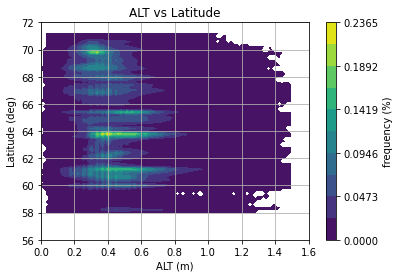

In [25]:
# set program control flags
do_2d_pdf    = True   # make 2_D pdfs
composite    = False   # make multi-swath composite vector
print_flag   = False  # print detailed diagnostics
plot_hist    = False   # make histograms of variables 
plot_scat    = False   # make scatterplots
display      = True   # display plots to screne as well as to a file
calc_stats   = False  # calculate statistics of each variable
print_header = True   # print statistics header (always set to true here)
missing = -9999.      # standard PDO missing value

# setup the pdf
if do_2d_pdf:
    numpt_pdf = 100
    pdf_alt_lat = np.zeros((numpt_pdf,numpt_pdf))
    lat_pdf = np.zeros((numpt_pdf))
    alt_pdf = np.zeros((numpt_pdf))
    delta =1.6/float(numpt_pdf)
    alt_pdf = np.arange(0, 1.6, step=delta)
    delta =20/float(numpt_pdf)
    lat_pdf = np.arange(55, 75, step=delta)

if composite:
    first_file = True

filter_data = False
if calc_stats:
    filter_data = true
if plot_hist:
    filter_data = true
if plot_scat:
    filter_data = true

# loop through the files
num_files=51 #51
for ifile in range(num_files):
    # read swath
    filename=V3_path+file_list[ifile]
    temp = file_list[ifile]
    swath=temp[11:17]
    nscan, nspot, alt, sub, vwc, lon, lat, has_vwc = read_pdo_version_3_netcdf_file(filename, print_flag)

    # GET COPERNICUS DEM
    toplat = np.amax(lat)
    botlat = np.amin(lat)
    leflon = np.amin(lon)
    riglon = np.amax(lon)
    #outdemfile = 
   # copcommand = r"/Users/elizabethwig/OneDrive - Stanford/Stanford_Research/PDO synthesis paper/" + "DEM/createDEMcop.py" +" "+"dem.rsc"+" "+"elevation.dem.rsc"+" "+str(toplat)+" "+str(botlat)+" "+str(leflon)+" "+str(riglon)
   # print(copcommand)
   # subprocess.run(copcommand)
    
    # create a pdf
    if do_2d_pdf:
        pdf_alt_lat = farm_to_2d_pdf(alt, lat, alt_pdf, lat_pdf, pdf_alt_lat, missing, print_flag)
        print(swath, np.max(pdf_alt_lat))


    # Combine all swaths into one huge ass vector
    # note this can choke the program
    if composite:
        if not first_file:
            tot_nrec, alt_mult = append_vector2_to_end_of_vector1(alt_mult, alt, missing, print_flag)
            tot_nrec, sub_mult = append_vector2_to_end_of_vector1(sub_mult, sub, missing, print_flag)
            tot_nrec, vwc_mult = append_vector2_to_end_of_vector1(vwc_mult, vwc, missing, print_flag)
            tot_nrec, lon_mult = append_vector2_to_end_of_vector1(lon_mult, lon, missing, print_flag)
            tot_nrec, lat_mult = append_vector2_to_end_of_vector1(lat_mult, lat, missing, print_flag)
        if first_file:
            alt_mult = alt
            sub_mult = sub
            vwc_mult = vwc
            lon_mult = lon
            lat_mult = lat
            first_file = False
            tot_nrec = len(lat)
    
    # filter out missing values
    if filter_data:
        num_alt, alt_filt = Filter_vector(alt, missing, print_flag)
        num_sub, sub_filt = Filter_vector(sub, missing, print_flag)
        alt_filt = alt_filt*100 # convert ALT to cm
        sub_filt = sub_filt*100 # convert subsidence to cm
        if has_vwc:
            num_vwc, vwc_filt = Filter_vector(vwc, missing, print_flag)

    # calculate swath statistics
    if calc_stats:
        var='ALT'
        units='(cm)'
        vector_statistics_row(alt_filt, swath, var, units, print_header)
        print_header=False

        var='Sub'
        units='(cm)'
        vector_statistics_row(sub_filt, swath, var, units, print_header)

        if has_vwc:
            var='VWC'
            units='(-)'
            vector_statistics_row(vwc_filt, swath, var, units, print_header)

        var='Lon'
        units='(deg)'
        vector_statistics_row(lon, swath, var, units, print_header)

        var='Lat'
        units='(deg)'
        vector_statistics_row(lat, swath, var, units, print_header)

    # plot Histograms
    if plot_hist:
        title = swath + ' ALT'
        xlabel='ALT (cm)'
        bmin = 0.
        bmax = 150.
        bdelta = 2.
        filename = out_path + 'hist_alt_' + swath +'.png'
        histogram_plot(alt_filt, title, xlabel, bmin, bmax, bdelta, filename, display)

        title = swath + ' Seasonal Subsidence'
        xlabel='Subsidence (cm)'
        bmin = 0.
        bmax = 6.
        bdelta = .02
        filename = out_path + 'hist_sub_' + swath +'.png'
        histogram_plot(sub_filt, title, xlabel, bmin, bmax, bdelta, filename, display)

        if has_vwc:
            title = swath + ' Volumetric Water Content'
            xlabel='VWC (-)'
            bmin = 0.
            bmax = 1.
            bdelta = .01
            filename = out_path + 'hist_vwc_' + swath +'.png'
            histogram_plot(vwc_filt, title, xlabel, bmin, bmax, bdelta, filename, display)

    if plot_scat:
        n_match, alt_match, sub_match = match_two_vectors(alt, sub, missing, print_flag)
        alt_match = alt_match*100 # convert ALT to cm
        sub_match = sub_match*100 # convert subsidence to cm
        title='ALT vs. Subsidence'
        xlab='Subsidence (cm)'
        xmin=0.
        xmax=6.
        deltax=1.
        ylab='ALT (cm)'
        ymin=0.
        ymax=150.
        deltay=20.
        filename= out_path + 'scat_alt_sub_'+swath+'.png'
        plot_scatter(sub_match, alt_match, title, xlab, xmin,xmax, deltax, ylab, ymin,ymax, deltay, filename, display)    

        if has_vwc:
            title='ALT vs. VWC'
            xlab='VWC (-)'
            xmin=0.
            xmax=1.
            deltax=.2
            ylab='ALT (cm)'
            ymin=0.
            ymax=150.
            deltay=20.
            filename= out_path + 'scat_alt_vwc_'+swath+'.png'
            plot_scatter(vwc_filt, alt_filt, title, xlab, xmin,xmax, deltax, ylab, ymin,ymax, deltay, filename, display)    

# overall multi-swath
if composite:
    n_match, alt_match, lat_match = match_two_vectors(alt_mult, lat_mult, missing, print_flag)
    alt_match = alt_match*100 # convert ALT to cm
    if calc_stats:
        swath = 'All'
        var='ALT'
        units='(m)'
        vector_statistics_row(alt_match, swath, var, units, print_header)

        var='lat'
        units='(deg)'
        vector_statistics_row(lat_match, swath, var, units, print_header)

    title='ALT vs. latitude'
    xlab='ALT (cm)'
    xmin=0.
    xmax=160
    deltax=20.
    ylab='Latitude (deg)'
    ymin=50.
    ymax=80.
    deltay=5.
    filename= out_path + 'scat_alt_sub_'+swath+'.png'
    plot_scatter(alt_match, lat_match, title, xlab, xmin,xmax, deltax, ylab, ymin,ymax, deltay, filename, display)    

if do_2d_pdf:
    # alt_pdf, lat_pdf, pdf_alt_lat
    total = np.sum(pdf_alt_lat)
    pdf_alt_lat = pdf_alt_lat/total*100
    pdf_masked = np.ma.masked_where(pdf_alt_lat == 0. , pdf_alt_lat)
    xmin  =0
    xmax  =1.6
    deltax=.2
    ymin  =56
    ymax  =72
    deltay=2.
    cmin = 0.
    cmax = np.max(pdf_alt_lat)
    deltac =cmax/10
    title='ALT vs Latitude'
    labx="ALT (m)"
    laby="Latitude (deg)"
    labcon='frequency (%)'
    filename= out_path + 'pdf_alt_lat_'+swath+'.png'
    plot_contour(alt_pdf, lat_pdf, pdf_masked, xmin,xmax, deltax, ymin,ymax, deltay,cmin, cmax, deltac,labx, laby, labcon, title, filename)
print('Done!')